# Prototype - Adversarial Detector
---

## Load Required Model & Data

In [2]:
# load model
from tensorflow import keras

model_ids = keras.models.load_model('../CICIDS2017/models/ids_dnn_poc.keras')
model_ids.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         3,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,938 (62.26 KB)

 Trainable params: 5,312 (20.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,626 (41.51 KB)

In [29]:
# load data split
import pandas as pd

X_test = pd.read_csv("../CICIDS2017/train_test_split/X_test_poc.csv")
y_test = pd.read_csv("../CICIDS2017/train_test_split/y_test_poc.csv")

print(X_test.shape, y_test.shape)


(64013, 68) (64013, 2)


In [30]:
# POC: create smaller dataset
X_test = X_test[:2500]
y_test = y_test[:2500]

print(X_test.shape, y_test.shape)

(2500, 68) (2500, 2)


In [31]:
# load adversarail samples

# X_test_adv_fgsm = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_fgsm_proto.csv")
# X_test_adv_hsj = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_hsj_proto.csv")
X_test_adv_cw = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_cw_poc.csv")
print(X_test_adv_cw.shape)

(2500, 68)


In [32]:
# load explanations

shap_values_df = pd.read_csv("../CICIDS2017/shap_values/shap_values_poc.csv")
print(shap_values_df.shape)
# adv_shap_values_fgsm_df = pd.read_csv("../CICIDS2017/shap_values/adv_shap_values_fgsm_proto.csv")
# print(adv_shap_values_fgsm_df.shape)
# adv_shap_values_hsj_df = pd.read_csv("../CICIDS2017/shap_values/adv_shap_values_hsj_proto.csv")
# print(adv_shap_values_hsj_df.shape)
adv_shap_values_cw_df = pd.read_csv("../CICIDS2017/shap_values/adv_shap_values_cw_poc.csv")
print(adv_shap_values_cw_df.shape)

(2500, 68)
(2500, 68)


---
## First Stage

### Normal Prediction

In [33]:
y_pred = model_ids.predict(X_test)
# y_pred_adv_fgsm = model_ids.predict(X_test_adv_fgsm)
# y_pred_adv_hsj = model_ids.predict(X_test_adv_hsj)
y_pred_adv_cw = model_ids.predict(X_test_adv_cw)

# evaluate model
from sklearn.metrics import accuracy_score

print(f"Accuracy on test set: {accuracy_score(y_test, y_pred.round())*100:.2f}%")
# print(f"Accuracy on adversarial samples (FGSM): {accuracy_score(y_test, y_pred_adv_fgsm.round())*100:.2f}%")
# print(f"Accuracy on adversarial samples (HSJ): {accuracy_score(y_test, y_pred_adv_hsj.round())*100:.2f}%")
print(f"Accuracy on adversarial samples (CW): {accuracy_score(y_test, y_pred_adv_cw.round())*100:.2f}%")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
Accuracy on test set: 99.72%
Accuracy on adversarial samples (CW): 81.56%


### Find Benign Explanations

In [34]:
import numpy as np

# convert to binary, 1 == benign, 0 == malicious -> easier to work on
y_test_binary = np.array(y_test).argmin(axis=1)
y_pred_binary = y_pred.argmin(axis=1)
# adv_fgsm_pred_binary = y_pred_adv_fgsm.argmin(axis=1)
# adv_hsj_pred_binary = y_pred_adv_hsj.argmin(axis=1)
adv_cw_pred_binary = y_pred_adv_cw.argmin(axis=1)

In [35]:
print(f"Correct Labels:                           {y_test_binary[:10]}")

# find indices of correctly classified benign samples
correct_benign_classified_indices = np.where((y_test_binary == 1) & (y_pred_binary == 1))[0]
print(f"Predicted Labels:                         {y_pred_binary[:10]}")
print(f"Correctly classified benign samples:      {correct_benign_classified_indices[:10]}")

# find indices of adversarial samples that were classified as benign
# # FGSM
# adv_fgsm_benign_indices = np.where(adv_fgsm_pred_binary == 1)[0]
# print(f"Predicted Labels (FGSM):                  {adv_fgsm_pred_binary[:10]}")
# print(f"Adversarial samples classified as benign: {adv_fgsm_benign_indices[:10]}")
# # HSJ
# adv_hsj_benign_indices = np.where(adv_hsj_pred_binary == 1)[0]
# print(f"Predicted Labels (HSJ):                   {adv_hsj_pred_binary[:10]}")
# print(f"Adversarial samples classified as benign: {adv_hsj_benign_indices[:10]}")
# CW
adv_cw_benign_indices = np.where(adv_cw_pred_binary == 1)[0]
print(f"Predicted Labels (CW):                    {adv_cw_pred_binary[:10]}")
print(f"Adversarial samples classified as benign: {adv_cw_benign_indices[:10]}")

Correct Labels:                           [0 1 0 1 0 0 1 0 1 0]
Predicted Labels:                         [0 1 0 1 0 0 1 0 1 0]
Correctly classified benign samples:      [ 1  3  6  8 10 14 16 17 18 21]
Predicted Labels (CW):                    [1 1 0 1 0 0 1 1 1 1]
Adversarial samples classified as benign: [ 0  1  3  6  7  8  9 10 12 14]


---

## Build Detector

### Build Dataframe

In [36]:
print(f"Correct Labels:                           {y_test_binary[:10]}")

# find indices of correctly classified benign samples
correct_benign_classified_indices = np.where((y_test_binary == 1) & (y_pred_binary == 1))[0]
print(f"Predicted Labels:                         {y_pred_binary[:10]}")
print(f"Correctly classified benign samples:      {correct_benign_classified_indices[:10]}")

# find indices of adversarial samples that were classified as benign
# # FGSM
# adv_fgsm_benign_indices = np.where(adv_fgsm_pred_binary == 1)[0]
# print(f"Predicted Labels (FGSM):                  {adv_fgsm_pred_binary[:10]}")
# print(f"Adversarial samples classified as benign: {adv_fgsm_benign_indices[:10]}")
# # HSJ
# adv_hsj_benign_indices = np.where(adv_hsj_pred_binary == 1)[0]
# print(f"Predicted Labels (HSJ):                   {adv_hsj_pred_binary[:10]}")
# print(f"Adversarial samples classified as benign: {adv_hsj_benign_indices[:10]}")
# CW
adv_cw_benign_indices = np.where(adv_cw_pred_binary == 1)[0]
print(f"Predicted Labels (CW):                    {adv_cw_pred_binary[:10]}")
print(f"Adversarial samples classified as benign: {adv_cw_benign_indices[:10]}")

Correct Labels:                           [0 1 0 1 0 0 1 0 1 0]
Predicted Labels:                         [0 1 0 1 0 0 1 0 1 0]
Correctly classified benign samples:      [ 1  3  6  8 10 14 16 17 18 21]
Predicted Labels (CW):                    [1 1 0 1 0 0 1 1 1 1]
Adversarial samples classified as benign: [ 0  1  3  6  7  8  9 10 12 14]


In [37]:
# get shap values for correctly classified benign samples
print("Correctly classified benign samples:")
shap_values_benign_df = shap_values_df.iloc[correct_benign_classified_indices]
print(shap_values_benign_df.shape)

# get shap values for adversarial samples classified as benign
# # FGSM
# print("Adversarial samples classified as benign (FGSM):")
# adv_shap_values_fgsm_benign_df = adv_shap_values_fgsm_df.iloc[adv_fgsm_benign_indices]
# print(adv_shap_values_fgsm_benign_df.shape)
# # HSJ
# print("Adversarial samples classified as benign (HSJ):")
# adv_shap_values_hsj_benign_df = adv_shap_values_hsj_df.iloc[adv_hsj_benign_indices]
# print(adv_shap_values_hsj_benign_df.shape)
# CW
print("Adversarial samples classified as benign (CW):")
adv_shap_values_cw_benign_df = adv_shap_values_cw_df.iloc[adv_cw_benign_indices]
print(adv_shap_values_cw_benign_df.shape)

# build X
print("X:")
X = pd.concat([shap_values_benign_df, adv_shap_values_cw_benign_df], axis=0)
print(X.shape)

# build y 
# normal: [1, 0], adv: [0, 1]
print("y:")
y_normal = np.array([[1, 0]] * shap_values_benign_df.shape[0])
y_adv = np.array([[0, 1]] * (adv_shap_values_cw_benign_df.shape[0]))
print(y_normal.shape, y_adv.shape)
print(y_normal[0], y_adv[0])
y = np.concatenate([y_normal, y_adv], axis=0)
print(y.shape)

Correctly classified benign samples:
(1260, 68)
Adversarial samples classified as benign (CW):
(1655, 68)
X:
(2915, 68)
y:
(1260, 2) (1655, 2)
[1 0] [0 1]
(2915, 2)


### Normalization

In [38]:
# check for columns which contain only 0 values
print("Columns which contain only 0 values....")
zero_columns = X.columns[(X.sum() == 0)]
print(f"Zero Columns: {zero_columns}")
# drop columns with only 0 values
X.drop(columns=zero_columns, inplace=True)
print("Dropped Zero Columns....")
print(X.shape)

Columns which contain only 0 values....
Zero Columns: Index([], dtype='object')
Dropped Zero Columns....
(2915, 68)


In [39]:
from sklearn.preprocessing import MinMaxScaler

print("No Normalization....")
print(X[[' Destination Port', ' Flow Duration', ' Total Fwd Packets']].head(2))

# min-max normalization
print("Min-Max Normalization....")
min_max_scaler = MinMaxScaler()
min_max_norm_feature_df = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns)
print(min_max_norm_feature_df.shape)
print(min_max_norm_feature_df[[' Destination Port', ' Flow Duration', ' Total Fwd Packets']].head(2))

No Normalization....
   Destination Port  Flow Duration  Total Fwd Packets
1          0.187678      -0.004227           0.001033
3         -0.001924       0.000130           0.002741
Min-Max Normalization....
(2915, 68)
   Destination Port  Flow Duration  Total Fwd Packets
0          0.457949       0.170357           0.574688
1          0.100856       0.186099           0.591407


### Shuffle Data

In [40]:
# TODO: maybe not needed -> random_state in train-test-split
# shuffle both sets in the same way
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=31)

### Create Validation Set

In [41]:
from sklearn.model_selection import train_test_split
print(X.shape, y.shape)

X, X_val, y, y_val = train_test_split(X, y, test_size=0.15, random_state=31)

print(f"Val Shapes: {X_val.shape}, {y_val.shape}")
print(f"Shapes: {X.shape}, {y.shape}")

(2915, 68) (2915, 2)
Val Shapes: (729, 68), (729, 2)
Shapes: (2186, 68), (2186, 2)


### Split Train/Test Set

In [42]:
# spit data into train and test set

X_train_detector, X_test_detector, y_train_detector, y_test_detector = train_test_split(X, y, test_size=0.25, random_state=21)
print(X_train_detector.shape, X_test_detector.shape, y_train_detector.shape, y_test_detector.shape)

(1639, 68) (547, 68) (1639, 2) (547, 2)


### Model Creation

In [44]:
# Create DNN model from tensorflow
import setuptools.dist # needed to avoid error
import tensorflow as tf
from tensorflow import keras

# keras model for handling one hot encoded labels -> needed for attack creation
model_explainer = keras.Sequential()
model_explainer.add(keras.layers.Dense(50, input_dim=X_train_detector.shape[1], activation='relu')) # hidden layer
model_explainer.add(keras.layers.Dense(30, activation='relu')) # hidden layer
model_explainer.add(keras.layers.Dense(10, activation='relu')) # hidden layer
model_explainer.add(keras.layers.Dense(y_train_detector.shape[1], activation='softmax'))  # Output layer with softmax for one-hot encoding

# set learning rate
opt = keras.optimizers.Adam(learning_rate=0.001)
# compile the keras model
model_explainer.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

### Model Training

In [45]:
# fit the keras model on the dataset
model_explainer.fit(X_train_detector, y_train_detector, validation_data=(X_test_detector, y_test_detector), epochs=10, batch_size=100)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5896 - loss: 0.6899 - val_accuracy: 0.6709 - val_loss: 0.6821
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6936 - loss: 0.6795 - val_accuracy: 0.7057 - val_loss: 0.6684
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7299 - loss: 0.6622 - val_accuracy: 0.7532 - val_loss: 0.6460
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8040 - loss: 0.6334 - val_accuracy: 0.7916 - val_loss: 0.6113
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8235 - loss: 0.5965 - val_accuracy: 0.8428 - val_loss: 0.5647
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8566 - loss: 0.5470 - val_accuracy: 0.8757 - val_loss: 0.5051
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8983 - loss: 0.4808 - val_accuracy: 0.8995 - val_loss: 0.4379
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9168 - loss: 0.4120 - val_accuracy: 0.9415 - val_loss

---
## Evaluation

In [46]:
# predict first 10 samples
y_pred_single = model_explainer.predict(X_val)
print(X_val.iloc[0])
y_pred_single2 = y_pred_single.argmin(axis=1)
print(y_pred_single2[y_pred_single2 == 1].shape) # predicts only benign!

y_val2 = y_val.argmin(axis=1)
print(y_val2[250:300])

from sklearn.metrics import accuracy_score
print(f"Accuracy on validation set: {accuracy_score(y_val2, y_pred_single2)*100:.2f}%")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 Destination Port             -1.133021e-03
 Flow Duration                -1.493370e-02
 Total Fwd Packets             2.741955e-03
 Total Backward Packets        7.050481e-07
Total Length of Fwd Packets   -1.079330e-05
                                   ...     
 Active Min                   -3.812282e-05
Idle Mean                      2.419007e-05
 Idle Std                      2.333484e-02
 Idle Max                      7.726101e-03
 Idle Min                      1.717877e-03
Name: 1816, Length: 68, dtype: float64
(315,)
[0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0
 1 0 1 0 0 0 0 0 0 0 0 0 0]
Accuracy on validation set: 96.43%


In [47]:
y_pred_detector = model_explainer.predict(X_val)
y_pred_detector = (y_pred_detector > 0.5)

y_test_detector_binary = np.array(y_val).argmin(axis=1)
y_pred_detector_binary = y_pred_detector.argmin(axis=1)
print(y_test_detector_binary.shape, y_pred_detector_binary.shape)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(729,) (729,)


In [48]:
# print accuracy, precision, recall and f1-score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# print accuracy
print(f"Global Accuracy: {accuracy_score(y_val, y_pred_detector)*100:.2f}%")


# precision, recall, f1-score
print(classification_report(y_val, y_pred_detector, target_names=['NORMAL', 'ADVERSARIAL ATTACK']))

# print true positive rate, false positive rate, true negative rate, false negative rate
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test_detector_binary, y_pred_detector_binary).ravel()
print(f"True Negative Rate: {tn/(tn+fp)*100:.2f}%")
print(f"False Positive Rate: {fp/(tn+fp)*100:.2f}%")
print(f"True Positive Rate: {tp/(tp+fn)*100:.2f}%")
print(f"False Negative Rate: {fn/(tp+fn)*100:.2f}%")

Global Accuracy: 96.43%
                    precision    recall  f1-score   support

            NORMAL       0.97      0.95      0.96       319
ADVERSARIAL ATTACK       0.96      0.97      0.97       410

         micro avg       0.96      0.96      0.96       729
         macro avg       0.96      0.96      0.96       729
      weighted avg       0.96      0.96      0.96       729
       samples avg       0.96      0.96      0.96       729

True Negative Rate: 97.32%
False Positive Rate: 2.68%
True Positive Rate: 95.30%
False Negative Rate: 4.70%


In [49]:
# show number of false positives and false negatives
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


False Positives: 11
False Negatives: 15


In [50]:
# show false positive samples
fp_indices = np.where((y_test_detector_binary == 0) & (y_pred_detector_binary == 1))[0]
print(fp_indices)
# show false negative samples
fn_indices = np.where((y_test_detector_binary == 1) & (y_pred_detector_binary == 0))[0]
print(fn_indices)

[  6  34  60  89 111 142 305 334 554 564 659]
[ 55 158 186 311 319 411 485 522 543 547 595 600 639 649 699]


---
## Store Model

In [51]:
# save model
model_explainer.save('../CICIDS2017/models/ids_explainer_poc.keras')

---
## Explanations

In [110]:
import shap 

# init shap explainer
explainer = shap.Explainer(model_explainer, X_test_detector, feature_names=X_test_detector.columns)
shap_values = explainer(X_test_detector)

print(shap_values.shape)

PermutationExplainer explainer: 584it [00:42, 12.01it/s]                         

(583, 68, 2)


In [111]:
# convert shap values to correct format
print(shap_values.shape) # one shap value per feature per sample per class
shap_values = shap_values[:, :, 0] # 1 == Benign, 0 == Malicious
print(shap_values.shape) # one shap value per feature per sample

(583, 68, 2)
(583, 68)


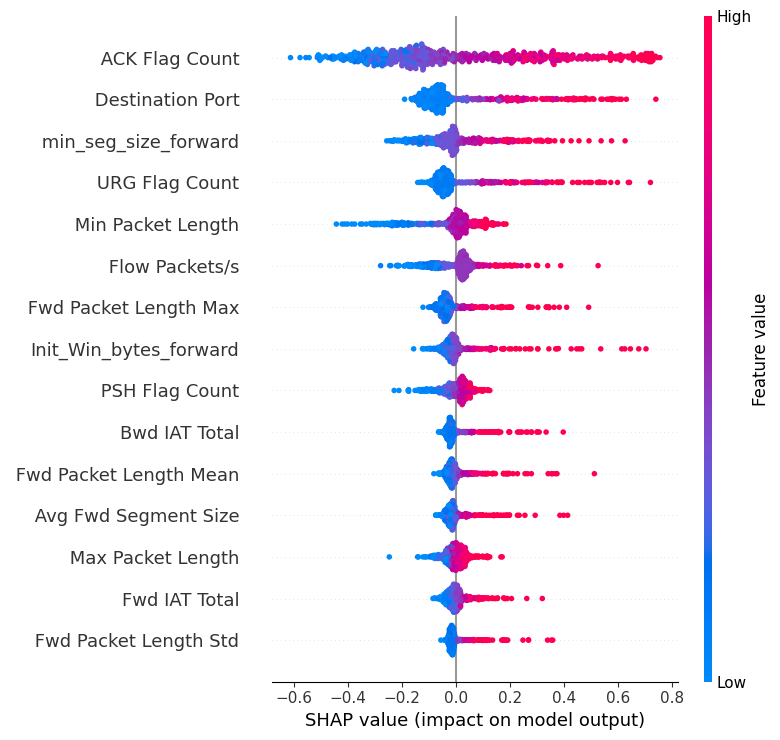

In [112]:
shap.summary_plot(shap_values, X_test_detector, max_display=15)